In [27]:
import IPython
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import pandas as pd 
from pandas.api.types import CategoricalDtype
import numpy as np 
from scipy.stats import iqr

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

colour_pal = sns.color_palette('flare')

### Energy Regions Map

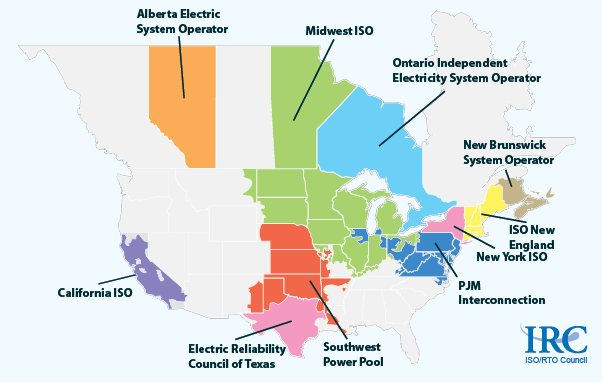

In [5]:
url = 'https://upload.wikimedia.org/wikipedia/commons/5/53/RTO_v2.png'
IPython.display.Image(url, width=1000)

Custom Function for Calculating Mean Absolute Percentage Error

In [6]:
def mean_absolute_percentage_error(y_true, y_pred):
    '''
    Mean Absolute Percentage Error (MAPE) Function
    
    y_true: list/series for actual values and predicted values
    y_pred: mape value 
    '''
   
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [7]:
def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column and the column data type.
    
    input: pandas df
    output: pandas df
    
    '''

    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in input_data.columns:
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return (pd.DataFrame(table))

### Load DataSet (PJM East)

In [8]:
pjme = pd.read_csv('DataSet/Regions/PJME_hourly.csv', index_col=[0], parse_dates=[0])
pjme.head(10)


,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
2002-12-31 06:00:00,26222.0
2002-12-31 07:00:00,28702.0
2002-12-31 08:00:00,30698.0
2002-12-31 09:00:00,31800.0


In [9]:
#Check for missing data
missing_data(pjme)

,Total,Percent,Types
PJME_MW,0,0.0,float64


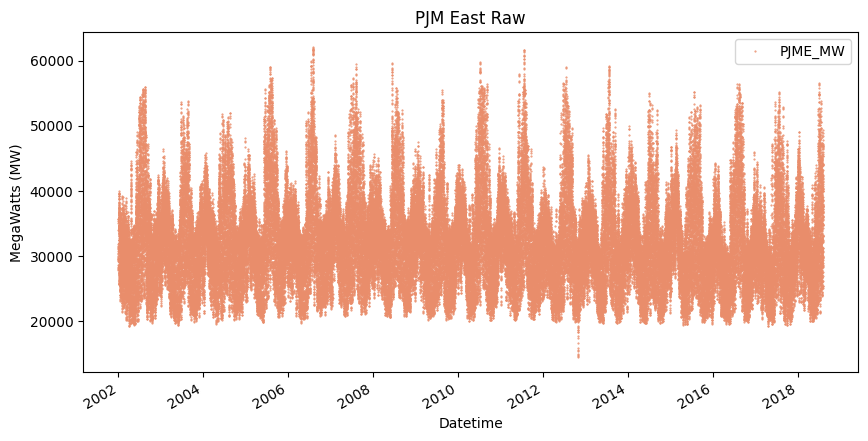

In [10]:
pjme.plot(style='.', figsize=(10,5),ms=1, color=colour_pal,ylabel='MegaWatts (MW)', title='PJM East Raw')
plt.show()

## Data Cleaning Requirements
1. Remove low-volume data that can't be predicted.
2. Remove situations where there's not enough data. (i.e. by visual inspection or by number of '0' daily sales counts.)
3. Remove outliers (automated by calculating z-score and just removing it and having Prophet impute those values). This will remove the outliers near 0 for all categories.
4. Check if more data needs to be removed after filtering to 08/15/15 - 08/15/17. If not, then we can move throughout the pipeline.

### Outlier Analysis and Removal 

In [11]:
pjme.describe()

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


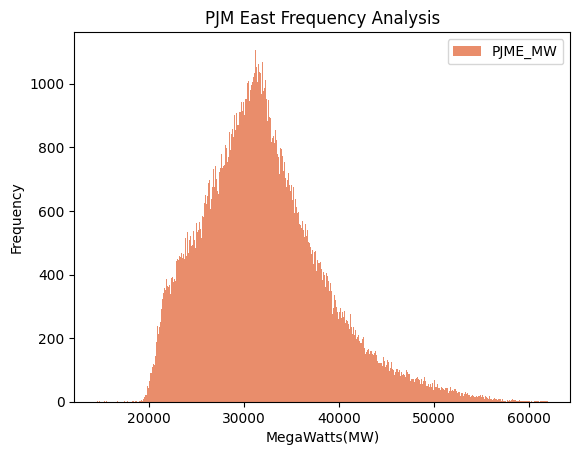

In [12]:
pjme.plot(kind='hist', bins=500, color=colour_pal,xlabel='MegaWatts(MW)', title='PJM East Frequency Analysis')
plt.show()

In [13]:
iqr_value = iqr(pjme['PJME_MW'])
lower_threshold = np.quantile(pjme['PJME_MW'], 0.25) - ((1.5) * (iqr_value))
upper_threshold = np.quantile(pjme['PJME_MW'], 0.75) + ((1.5) * (iqr_value))

print('Outlier threshold calculations:',f'IQR: {iqr_value}', f'Lower threshold:{lower_threshold}', f'Upper threshold: {upper_threshold}')

Outlier threshold calculations: IQR: 8077.0 Lower threshold:15457.5 Upper threshold: 47765.5


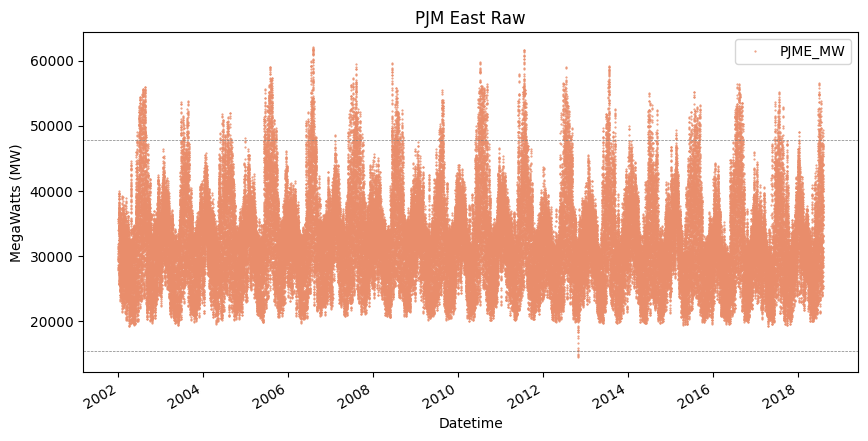

In [14]:
pjme.plot(style='.', figsize=(10, 5), ms=1, color=colour_pal,
          ylabel='MegaWatts (MW)', title='PJM East Raw')
plt.axhline(y=upper_threshold, color='grey', linestyle='--',linewidth=0.5)
plt.axhline(y=lower_threshold, color='grey', linestyle='--', linewidth=0.5)
plt.show()

In [15]:
pjme = pjme.query('PJME_MW <= @upper_threshold and PJME_MW >= @lower_threshold')

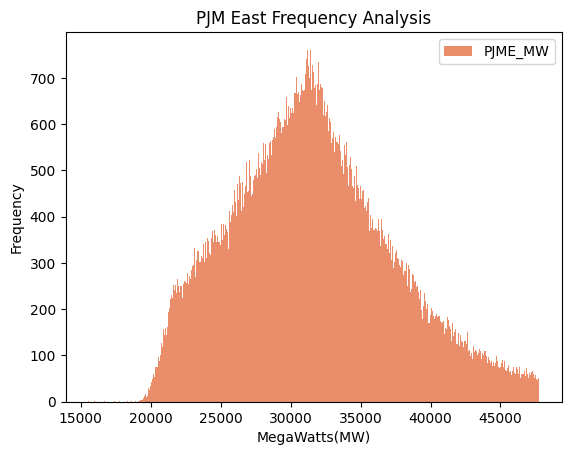

In [16]:
pjme.plot(kind='hist', bins=500, color=colour_pal, xlabel='MegaWatts(MW)', title='PJM East Frequency Analysis')
plt.show()

### Feature Creation

In [17]:
cat_type = CategoricalDtype(categories=['Monday', 'Tuesday',
                                        'Wednesday',
                                        'Thursday', 'Friday',
                                        'Saturday', 'Sunday'],
                            ordered=True)

In [36]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320) % 1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300],
                          labels=['Spring', 'Summer', 'Autumn', 'Winter']
                          )
    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year',
           'dayofyear', 'dayofmonth', 'weekday',
            'season']]
    if label:
        y = df[label]
        return X, y
    return X

In [37]:
X, y = create_features(pjme, label='PJME_MW')
features_and_target = pd.concat([X, y], axis=1)

In [38]:
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekday,season,PJME_MW
Datetime,,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,Tuesday,Winter,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,Tuesday,Winter,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,Tuesday,Winter,24574.0
2002-12-31 04:00:00,4,1,4,12,2002,365,31,Tuesday,Winter,24393.0
2002-12-31 05:00:00,5,1,4,12,2002,365,31,Tuesday,Winter,24860.0


### Visualizing Potential Seasonalities 
- Feature to target relationships

#### By Hour

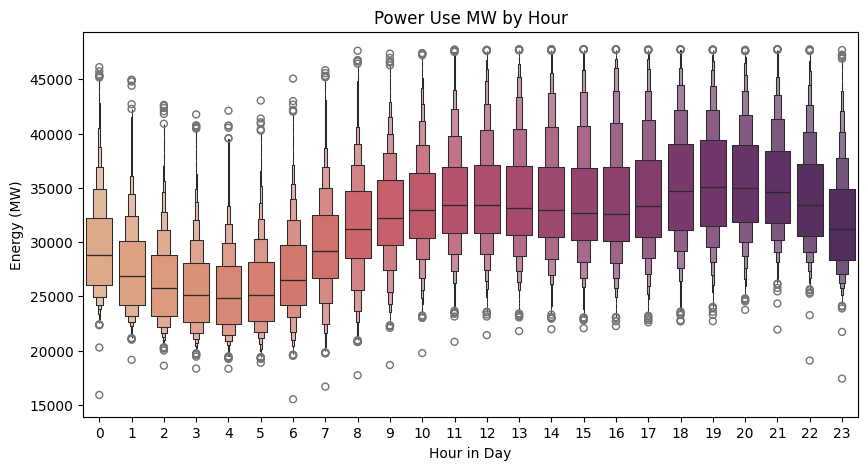

In [54]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxenplot(data=features_and_target.dropna(),
              x='hour',
              y='PJME_MW',
              palette='flare',
              ax=ax)
ax.set_title('Power Use MW by Hour')
ax.set_xlabel('Hour in Day')
ax.set_ylabel('Energy (MW)')
plt.show()

#### By Weekday

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


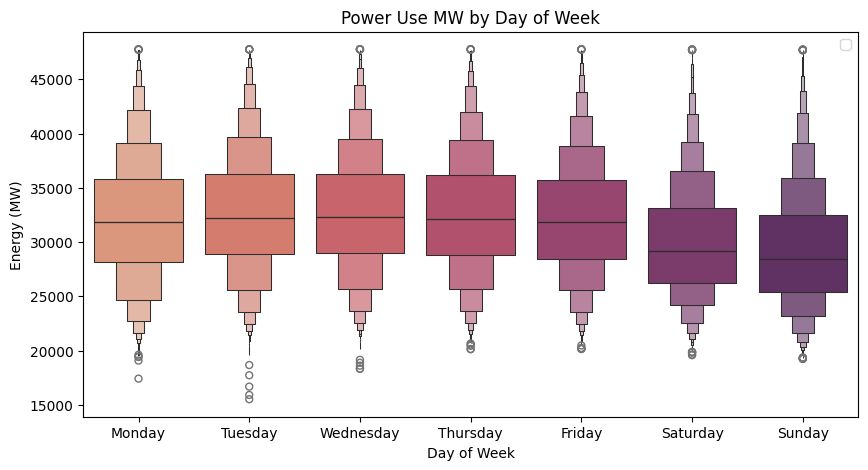

In [58]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxenplot(data=features_and_target.dropna(),
              x='weekday',
              y='PJME_MW',
              palette='flare',
              ax=ax)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

#### By Month

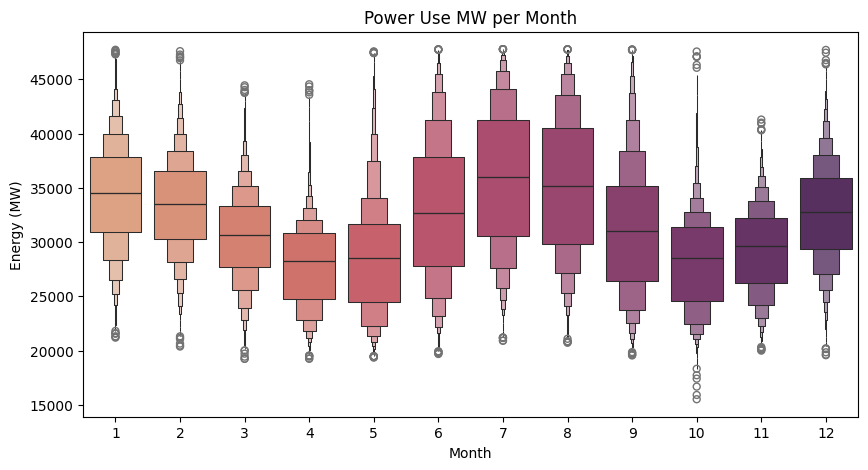

In [64]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxenplot(data=features_and_target.dropna(),
              x='month',
              y='PJME_MW',
              palette='flare',
              ax=ax)
ax.set_title('Power Use MW per Month')
ax.set_xlabel('Month')
ax.set_ylabel('Energy (MW)')
plt.show()

#### By Day of Year

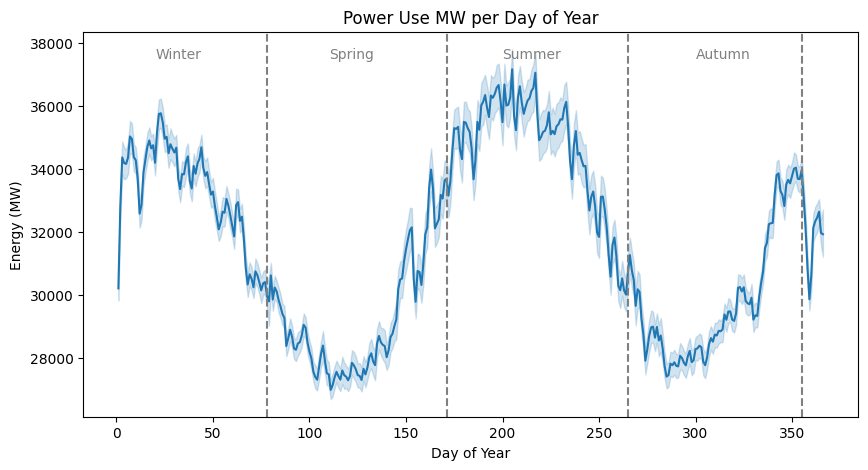

In [86]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=features_and_target.dropna(),
              x='dayofyear',
              y='PJME_MW',
              palette=colour_pal[2],
              ax=ax)
ax.set_title('Power Use MW per Day of Year')
ax.set_xlabel('Day of Year')
ax.set_ylabel('Energy (MW)')
plt.axvline(78,color='grey',linestyle='--')
ax.text(110,37500,'Spring', color='grey')
plt.axvline(171,color='grey',linestyle='--')
ax.text(200, 37500, 'Summer', color='grey')
plt.axvline(265,color='grey',linestyle='--')
ax.text(300, 37500, 'Autumn', color='grey')
plt.axvline(355,color='grey',linestyle='--')
ax.text(20, 37500, 'Winter', color='grey')

plt.show()

#### By Season

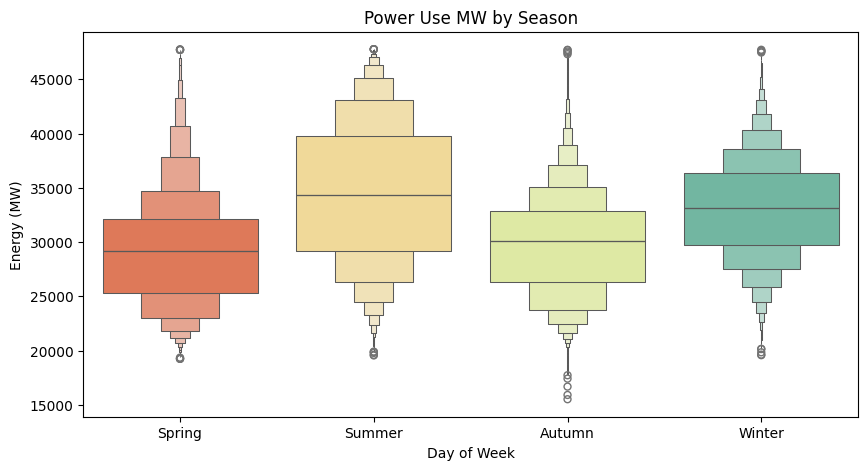

In [87]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxenplot(data=features_and_target.dropna(),
            x='season',
            y='PJME_MW',
            palette='Spectral',
            ax=ax)
ax.set_title('Power Use MW by Season')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
plt.show()

#### Add Holidays

In [22]:
cal = calendar()


holidays = cal.holidays(start=pjme.index.min(),
                        end=pjme.index.max(),
                        return_name=True)
holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday'])
holiday_df = holiday_df.reset_index().rename(columns={'index': 'ds'})

### Train/Test Split
- will split train and test on Jan 01  (80:20 split)


In [23]:
print('Min:', min(features_and_target.index), 'Max:', max(features_and_target.index),'Timedelta:', (max(features_and_target.index)-min(features_and_target.index)))

Min: 2002-01-01 01:00:00 Max: 2018-08-03 00:00:00 Timedelta: 6057 days 23:00:00


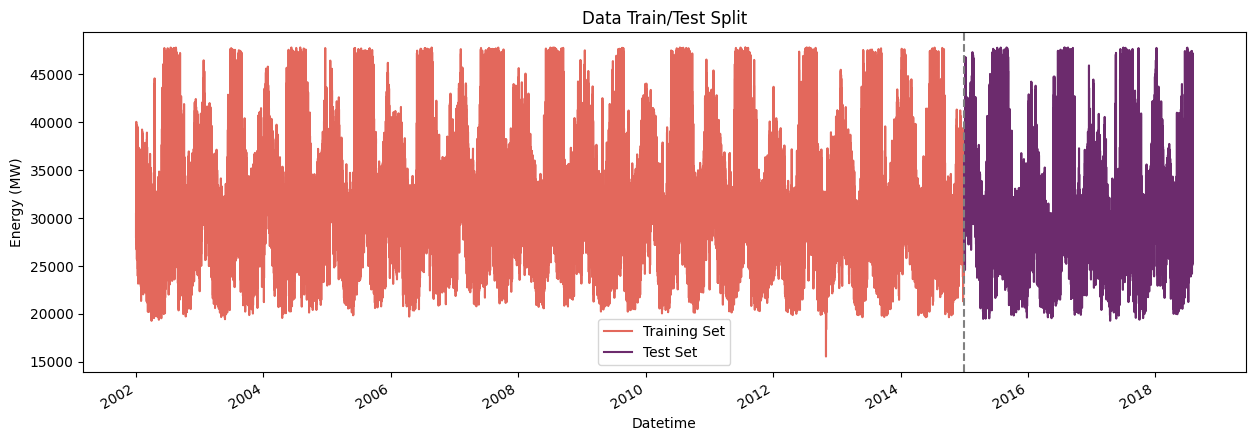

In [61]:
pjme_train = features_and_target.loc[features_and_target.index < '01-01-2015']
pjme_test = features_and_target.loc[features_and_target.index > '01-01-2015']

fig, ax =plt.subplots(figsize=(15,5))
pjme_train.plot( y='PJME_MW', ax=ax, label='Training Set',
                color=colour_pal[1], title='Data Train/Test Split')
pjme_test.plot( y='PJME_MW', ax=ax,
               label='Test Set', color=colour_pal[5])
ax.axvline('01-01-2015', color='grey', ls='--')
ax.legend(['Training Set', 'Test Set'])
ax.set_ylabel('Energy (MW)')
plt.show()

### Initial Prophet Model

In [89]:
pjme_train_prophet = pjme_train.reset_index() \
    .rename(columns={'Datetime': 'ds',
                     'PJME_MW': 'y'})

In [90]:
%%time
model = Prophet(holidays=holiday_df)
model.fit(pjme_train_prophet)

11:44:23 - cmdstanpy - INFO - Chain [1] start processing
11:44:47 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 3.7 s, sys: 94.7 ms, total: 3.79 s
Wall time: 27.6 s


In [91]:
pjme_test_prophet = pjme_test.reset_index() \
    .rename(columns={'Datetime': 'ds',
                     'PJME_MW': 'y'})
pjme_test_fcst = model.predict(pjme_test_prophet)

pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,"Birthday of Martin Luther King, Jr.","Birthday of Martin Luther King, Jr._lower","Birthday of Martin Luther King, Jr._upper",Christmas Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31195.139719,22220.770747,29642.169023,31195.139719,31195.139719,0.0,0.0,0.0,0.0,...,1225.432421,1225.432421,1225.432421,886.778854,886.778854,886.778854,0.0,0.0,0.0,25996.450042
1,2015-01-01 02:00:00,31195.116197,20633.061463,28218.513093,31195.116197,31195.116197,0.0,0.0,0.0,0.0,...,1221.241506,1221.241506,1221.241506,887.734455,887.734455,887.734455,0.0,0.0,0.0,24511.796952
2,2015-01-01 03:00:00,31195.092675,19942.441465,27795.854416,31195.092675,31195.092675,0.0,0.0,0.0,0.0,...,1215.504549,1215.504549,1215.504549,888.724293,888.724293,888.724293,0.0,0.0,0.0,23639.515606
3,2015-01-01 04:00:00,31195.069154,19754.988937,27348.719220,31195.069154,31195.069154,0.0,0.0,0.0,0.0,...,1208.324140,1208.324140,1208.324140,889.748407,889.748407,889.748407,0.0,0.0,0.0,23486.205842
4,2015-01-01 05:00:00,31195.045632,20110.938367,28013.069747,31195.045632,31195.045632,0.0,0.0,0.0,0.0,...,1199.818959,1199.818959,1199.818959,890.806833,890.806833,890.806833,0.0,0.0,0.0,24153.560081


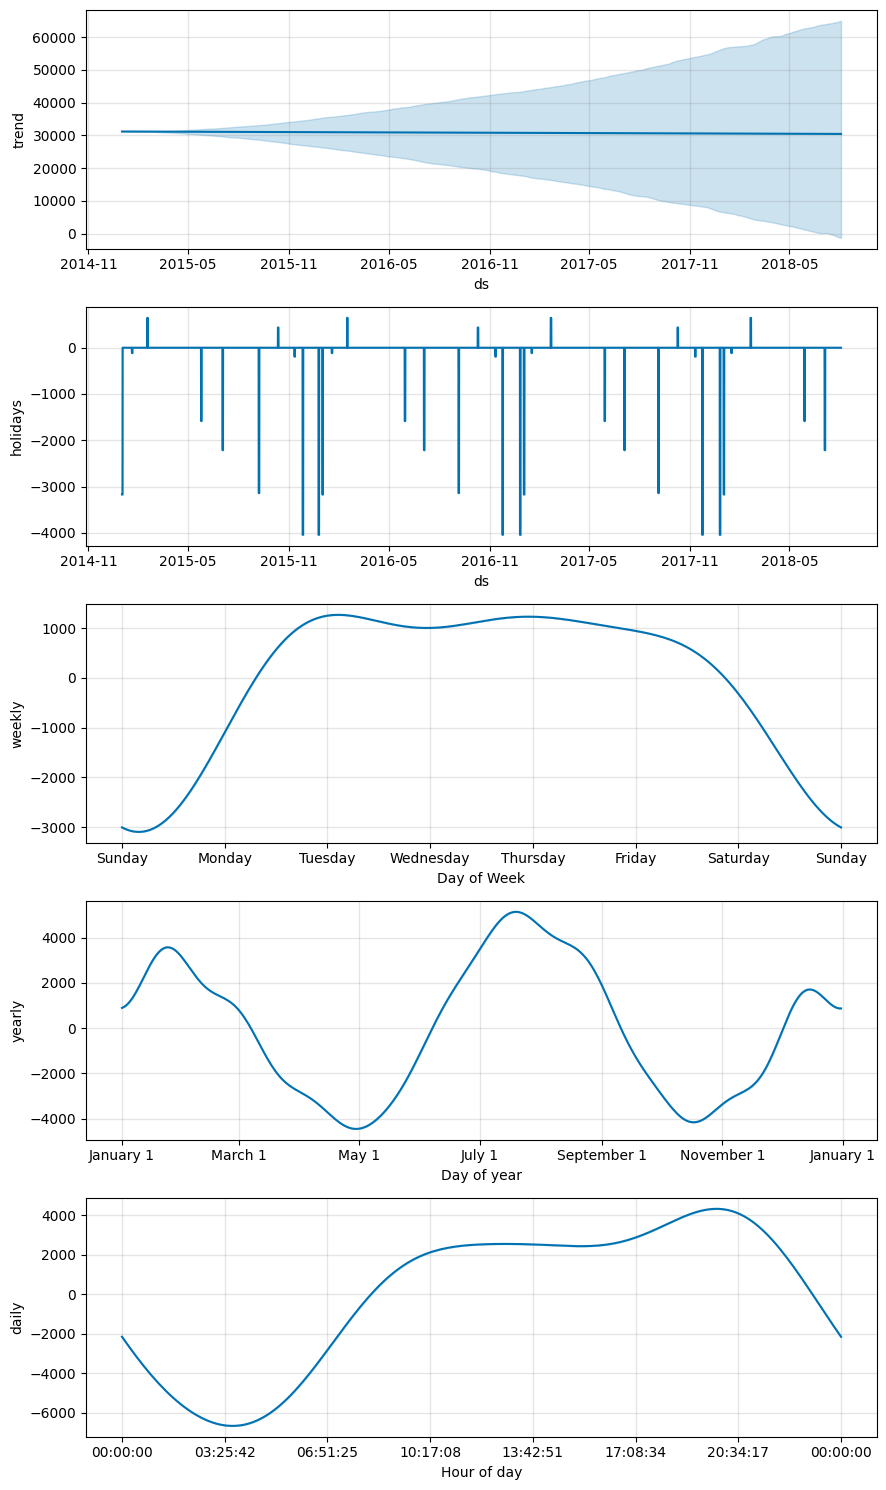

In [93]:

fig = model.plot_components(pjme_test_fcst)


### Visual Comparison of Forecast to Test

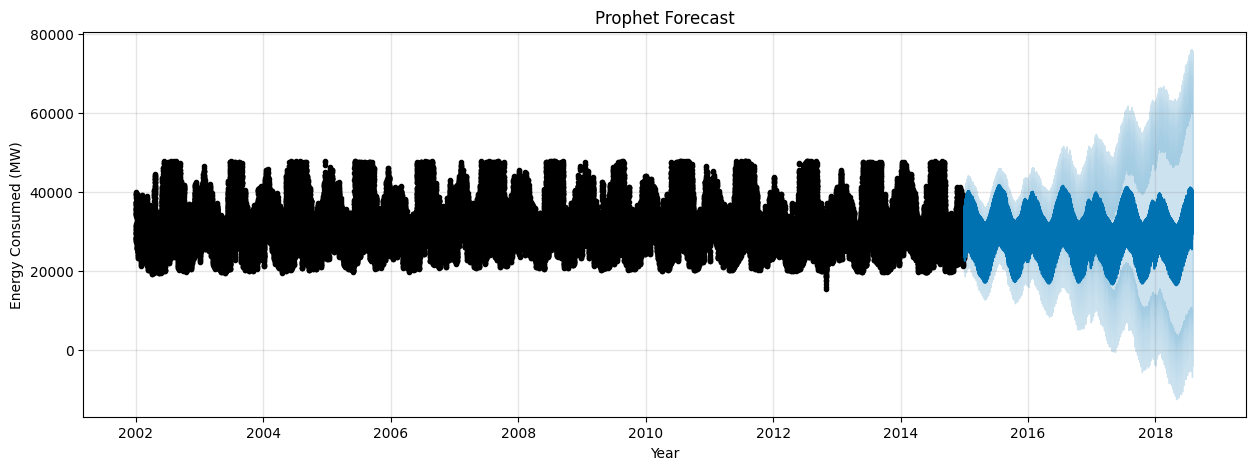

In [94]:
f, ax = plt.subplots(figsize=(15, 5))
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set(title='Prophet Forecast', xlabel='Year', ylabel='Energy Consumed (MW)')
plt.show()

#### For One Month

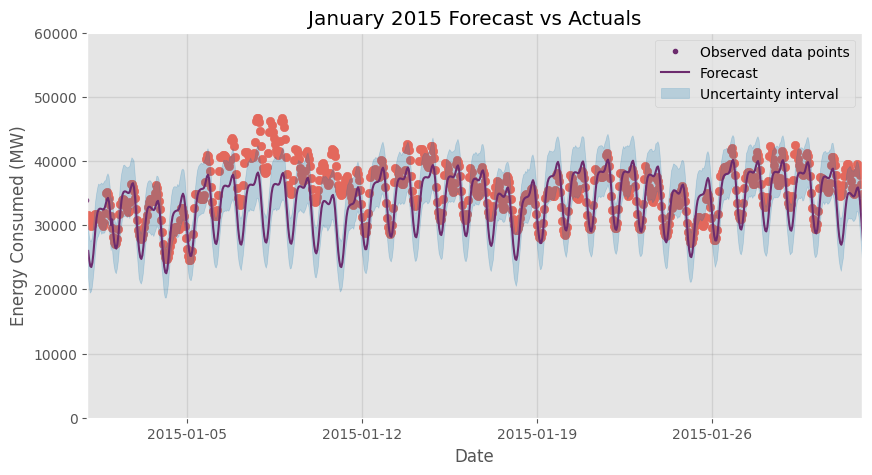

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color=colour_pal[1])
fig = model.plot(pjme_test_fcst, ax=ax)
for line in ax.get_lines():
    line.set_color(colour_pal[5])
ax.set_xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2015-02-01'))
ax.set_ylim(0, 60000)
ax.set(title='January 2015 Forecast vs Actuals',
       xlabel='Date', ylabel='Energy Consumed (MW)')
ax.legend()
plt.show()

#### For One Week

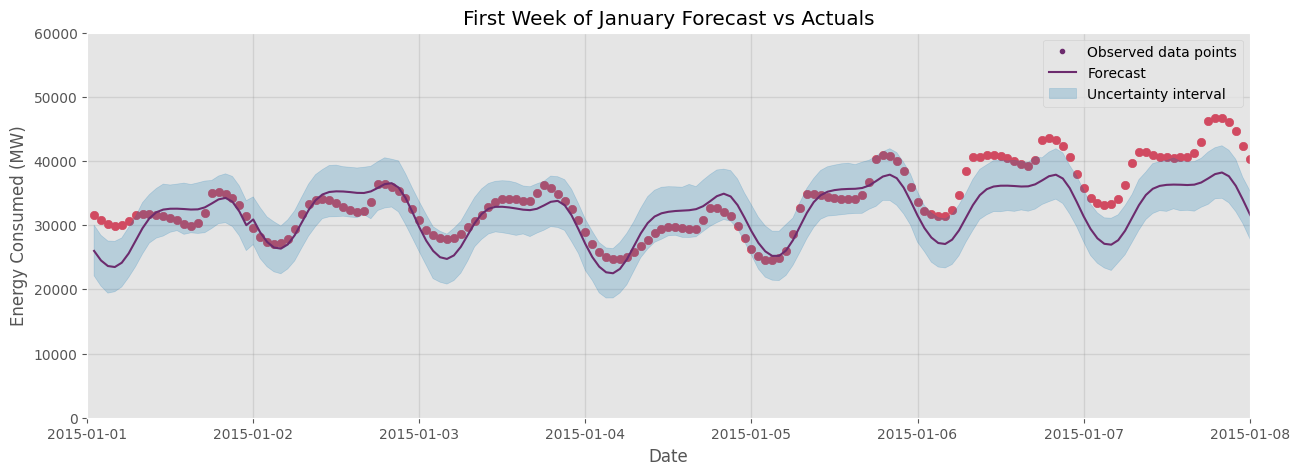

In [ ]:
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color=colour_pal[2])
fig = model.plot(pjme_test_fcst, ax=ax)
for line in ax.get_lines():
    line.set_color(colour_pal[5])
ax.set_xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2015-01-08'))
ax.set_ylim(0, 60000)
ax.legend()
ax.set(title='First Week of January Forecast vs Actuals', xlabel='Date', ylabel='Energy Consumed (MW)')
plt.show()

### Evaluate Simple Model (Error Metrics)

In [ ]:
print('RMSE:', np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                           y_pred=pjme_test_fcst['yhat'])))

RMSE: 3739.154596764282


In [ ]:
print('MSE:',mean_absolute_error(y_true=pjme_test['PJME_MW'],
                    y_pred=pjme_test_fcst['yhat']))

MSE: 2884.562338691256


In [ ]:
print('MAPE:',mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                               y_pred=pjme_test_fcst['yhat']))

MAPE: 9.134498945740575


### Cross Validation

In [101]:
m = Prophet(holidays=holiday_df, seasonality_mode='multiplicative')
m.fit(pjme_train_prophet)
#730 hours = 1 month
cv_results = cross_validation(
    m, initial='111065 hours', period='730 hours', horizon='730 hours')

11:50:00 - cmdstanpy - INFO - Chain [1] start processing
11:50:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

11:50:31 - cmdstanpy - INFO - Chain [1] start processing
11:51:04 - cmdstanpy - INFO - Chain [1] done processing
11:51:08 - cmdstanpy - INFO - Chain [1] start processing
11:51:34 - cmdstanpy - INFO - Chain [1] done processing
11:51:38 - cmdstanpy - INFO - Chain [1] start processing
11:52:16 - cmdstanpy - INFO - Chain [1] done processing


In [102]:
cv_results['mape'] = (cv_results['y']-cv_results['yhat'])/(cv_results['y']) *100
cv_results['overestimate'] = cv_results['yhat'] > cv_results['y']
cv_results

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,mape,overestimate
0,2014-10-01 18:00:00,33247.273475,29002.757534,37138.549484,32030.0,2014-10-01 17:00:00,-3.800417,True
1,2014-10-01 19:00:00,33893.704627,30122.923076,37471.066207,32019.0,2014-10-01 17:00:00,-5.854976,True
2,2014-10-01 20:00:00,34132.172767,30289.341623,37839.004972,33026.0,2014-10-01 17:00:00,-3.349400,True
3,2014-10-01 21:00:00,33557.747672,29698.712922,37357.914293,32173.0,2014-10-01 17:00:00,-4.304068,True
4,2014-10-01 22:00:00,32080.833901,28196.063355,36150.232206,30281.0,2014-10-01 17:00:00,-5.943773,True
...,...,...,...,...,...,...,...,...
2186,2014-12-31 19:00:00,37524.624262,33641.260816,41396.273509,38906.0,2014-12-01 13:00:00,3.550547,False
2187,2014-12-31 20:00:00,37764.395277,33722.541615,41438.972665,37772.0,2014-12-01 13:00:00,0.020133,False
2188,2014-12-31 21:00:00,37194.655065,33213.706051,41382.637827,36602.0,2014-12-01 13:00:00,-1.619188,True
2189,2014-12-31 22:00:00,35730.374657,31814.436531,39736.782325,35326.0,2014-12-01 13:00:00,-1.144694,True


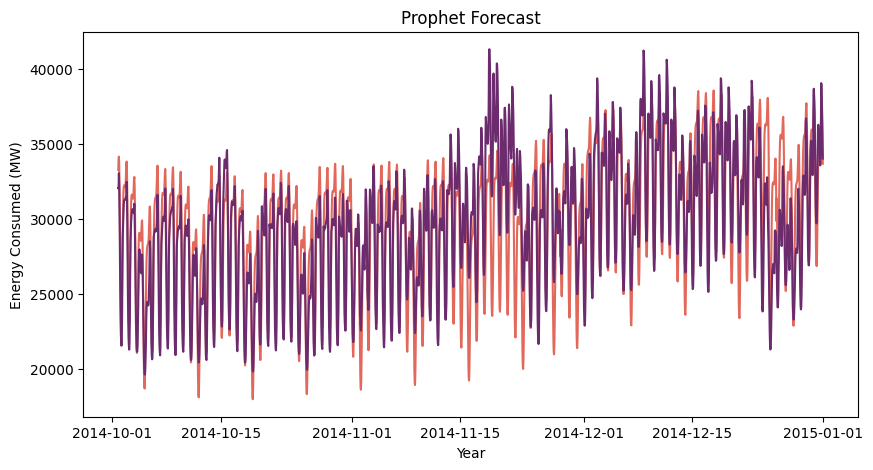

In [103]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(cv_results['ds'], cv_results['yhat'], color=colour_pal[1])
ax.plot(cv_results['ds'], cv_results['y'], color=colour_pal[5])
ax.set(title='Prophet Forecast', xlabel='Year', ylabel='Energy Consumed (MW)')
plt.show()

In [104]:
cv_metrics = performance_metrics(cv_results)
cv_metrics.tail()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
653,30 days 06:00:00,4.389916e+06,2095.212690,1838.684814,0.062424,0.061122,0.061913,0.977169
654,30 days 07:00:00,4.374371e+06,2091.499775,1829.747552,0.062128,0.060855,0.061628,0.977169
655,30 days 08:00:00,4.347199e+06,2084.993730,1816.845264,0.061641,0.060837,0.061160,0.977169
656,30 days 09:00:00,4.332066e+06,2081.361551,1804.813085,0.061171,0.060561,0.060707,0.972603
657,30 days 10:00:00,4.342883e+06,2083.958379,1798.318340,0.060903,0.060492,0.060446,0.968037


In [105]:
print('RMSE:', np.sqrt(mean_squared_error(y_true=cv_results['y'],
                                          y_pred=cv_results['yhat'])))

RMSE: 2415.560417870197


In [106]:
print('MSE:', mean_absolute_error(y_true=cv_results['y'],
                                  y_pred=cv_results['yhat']))

MSE: 1909.7645933073636


In [107]:
print('MAPE:', mean_absolute_percentage_error(y_true=cv_results['y'],
                                              y_pred=cv_results['yhat']))

MAPE: 6.528545488834577


## Tuning Prophet Model Hyperparameters

In [ ]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

In [ ]:
import itertools

#Generates all combinations of parameters
all_params = [dict(zip(param_grid.keys(),v)) for v in itertools.product(*param_grid.values())]

rmse = []

for param in all_params:
    pmodel = Prophet(holidays=holiday_df,seasonality_mode='multiplicative', **param).fit(pjme_train_prophet)
    df_cv = cross_validation(pmodel, initial='111065 hours', period='730 hours', horizon='730 hours', parallel='processes' )
    df_performance = performance_metrics(df_cv, rolling_window=1)
    rmse.append(df_performance['rmse'].iloc[0])

#Find Best Parameter
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmse

13:01:53 - cmdstanpy - INFO - Chain [1] start processing
13:01:57 - cmdstanpy - INFO - Chain [1] done processing
13:02:01 - cmdstanpy - INFO - Chain [1] start processing
13:02:02 - cmdstanpy - INFO - Chain [1] start processing
13:02:02 - cmdstanpy - INFO - Chain [1] start processing
13:02:07 - cmdstanpy - INFO - Chain [1] done processing
13:02:07 - cmdstanpy - INFO - Chain [1] done processing
13:02:08 - cmdstanpy - INFO - Chain [1] done processing
13:02:12 - cmdstanpy - INFO - Chain [1] start processing
13:02:16 - cmdstanpy - INFO - Chain [1] done processing
13:02:21 - cmdstanpy - INFO - Chain [1] start processing
13:02:21 - cmdstanpy - INFO - Chain [1] start processing
13:02:21 - cmdstanpy - INFO - Chain [1] start processing
13:02:26 - cmdstanpy - INFO - Chain [1] done processing
13:02:28 - cmdstanpy - INFO - Chain [1] done processing
13:02:29 - cmdstanpy - INFO - Chain [1] done processing
13:02:33 - cmdstanpy - INFO - Chain [1] start processing
13:02:36 - cmdstanpy - INFO - Chain [1]

In [ ]:

print(tuning_results.head())

params_dict = dict(tuning_results.sort_values("rmse").reset_index(drop=True).iloc[0])
params_dict

   changepoint_prior_scale  seasonality_prior_scale         rmse
0                    0.001                     0.01  2369.932612
1                    0.001                     0.10  2374.752717
2                    0.001                     1.00  2372.152807
3                    0.001                    10.00  2370.938476
4                    0.010                     0.01  2412.323087


{'changepoint_prior_scale': 0.001,
 'seasonality_prior_scale': 0.01,
 'rmse': 2369.9326122195885}

### Backtesting With Tuned Metrics

In [109]:
m = Prophet(changepoint_prior_scale = 0.001,
             seasonality_prior_scale = 0.01,
            seasonality_mode='multiplicative',
             holidays= holiday_df)

m.fit(pjme_train_prophet)
cv_results = cross_validation(
    m, initial='111065 hours', period='730 hours', horizon='730 hours')
forecast = m.predict(pjme_test_prophet)

12:02:50 - cmdstanpy - INFO - Chain [1] start processing
12:02:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

12:02:57 - cmdstanpy - INFO - Chain [1] start processing
12:03:01 - cmdstanpy - INFO - Chain [1] done processing
12:03:05 - cmdstanpy - INFO - Chain [1] start processing
12:03:09 - cmdstanpy - INFO - Chain [1] done processing
12:03:13 - cmdstanpy - INFO - Chain [1] start processing
12:03:18 - cmdstanpy - INFO - Chain [1] done processing


In [110]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,"Birthday of Martin Luther King, Jr.","Birthday of Martin Luther King, Jr._lower","Birthday of Martin Luther King, Jr._upper",Christmas Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2015-01-01 01:00:00,31091.469007,21686.226959,29834.290092,31091.469007,31091.469007,0.0,0.0,0.0,0.0,...,0.038007,0.038007,0.038007,0.022132,0.022132,0.022132,0.0,0.0,0.0,26097.934373
1,2015-01-01 02:00:00,31091.442023,20959.869701,28366.962853,31091.442023,31091.442023,0.0,0.0,0.0,0.0,...,0.037881,0.037881,0.037881,0.022145,0.022145,0.022145,0.0,0.0,0.0,24659.182733
2,2015-01-01 03:00:00,31091.415039,19525.246768,27824.522025,31091.415039,31091.415039,0.0,0.0,0.0,0.0,...,0.037707,0.037707,0.037707,0.022159,0.022159,0.022159,0.0,0.0,0.0,23813.450676
3,2015-01-01 04:00:00,31091.388054,19803.607477,27787.050538,31091.388054,31091.388054,0.0,0.0,0.0,0.0,...,0.037489,0.037489,0.037489,0.022174,0.022174,0.022174,0.0,0.0,0.0,23664.219303
4,2015-01-01 05:00:00,31091.361070,20306.104235,28395.019121,31091.361070,31091.361070,0.0,0.0,0.0,0.0,...,0.037230,0.037230,0.037230,0.022190,0.022190,0.022190,0.0,0.0,0.0,24310.201505


In [111]:
pjme_test_prophet.columns

Index(['ds', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekday', 'season', 'y'],
      dtype='object')

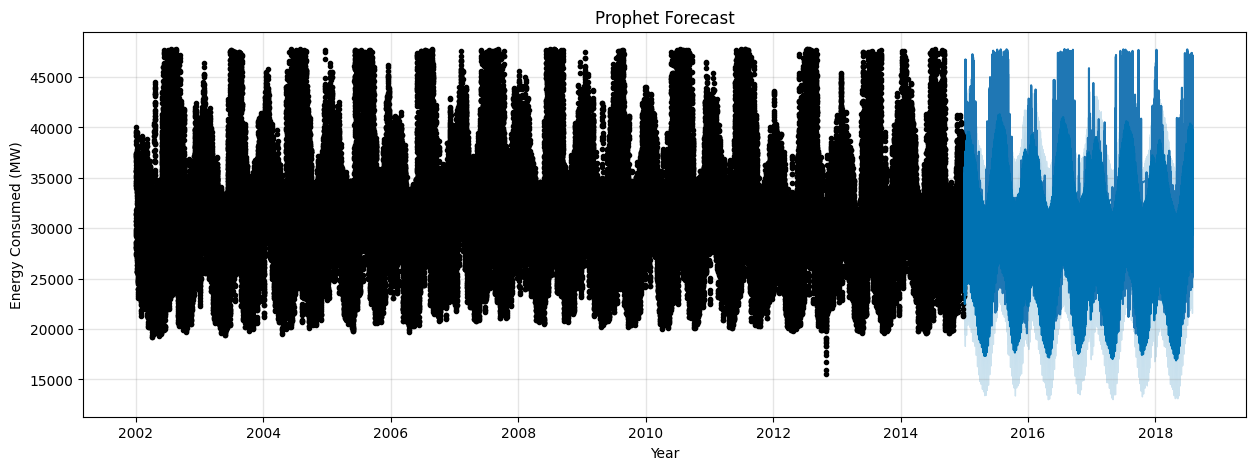

In [112]:
f, ax = plt.subplots(figsize=(15, 5))
ax.plot(pjme_test.index, pjme_test['PJME_MW'])
fig = m.plot(forecast, ax=ax)
ax.set(title='Prophet Forecast', xlabel='Year', ylabel='Energy Consumed (MW)')
plt.show()

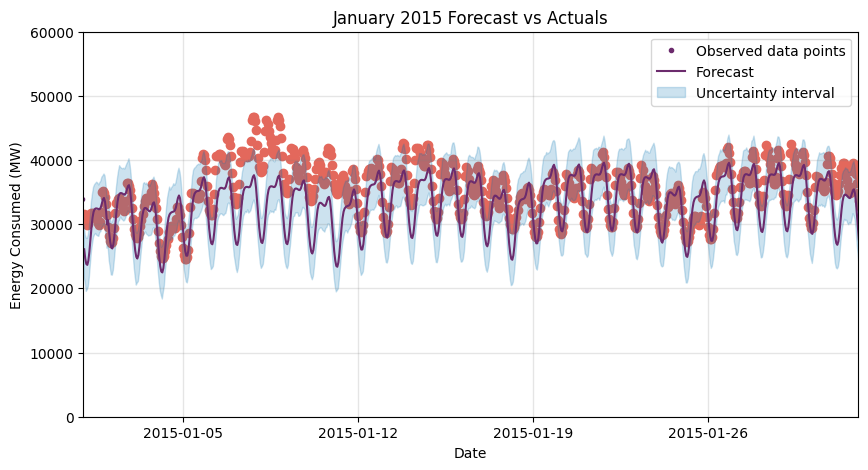

In [113]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color=colour_pal[1])
fig = m.plot(forecast, ax=ax)
for line in ax.get_lines():
    line.set_color(colour_pal[5])
ax.set_xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2015-02-01'))
ax.set_ylim(0, 60000)
ax.set(title='January 2015 Forecast vs Actuals',
       xlabel='Date', ylabel='Energy Consumed (MW)')
ax.legend()
plt.show()

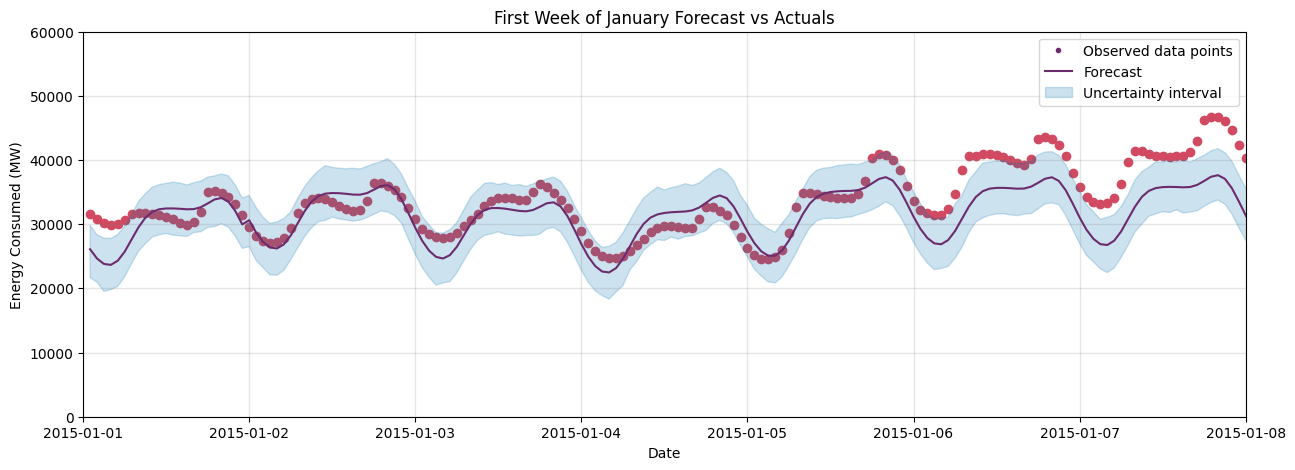

In [114]:
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color=colour_pal[2])
fig = m.plot(forecast, ax=ax)
for line in ax.get_lines():
    line.set_color(colour_pal[5])
ax.set_xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2015-01-08'))
ax.set_ylim(0, 60000)
ax.legend()
ax.set(title='First Week of January Forecast vs Actuals',
       xlabel='Date', ylabel='Energy Consumed (MW)')
plt.show()

In [119]:
print('RMSE:', np.sqrt(mean_squared_error(y_true=cv_results['y'],
                                          y_pred=cv_results['yhat'])))

RMSE: 2369.93261221959


In [120]:
print('MAPE:', mean_absolute_percentage_error(y_true=cv_results['y'],
                                              y_pred=cv_results['yhat']))

MAPE: 6.252491397861504


### Predict into Future

In [122]:
future = m.make_future_dataframe(
    periods=365*24*4, freq='h', include_history=False)
forecast = m.predict(future)

In [123]:
forecast[['ds', 'yhat']].head()

,ds,yhat
0,2015-01-01 00:00:00,28022.451931
1,2015-01-01 01:00:00,26097.934373
2,2015-01-01 02:00:00,24659.182733
3,2015-01-01 03:00:00,23813.450676
4,2015-01-01 04:00:00,23664.219303


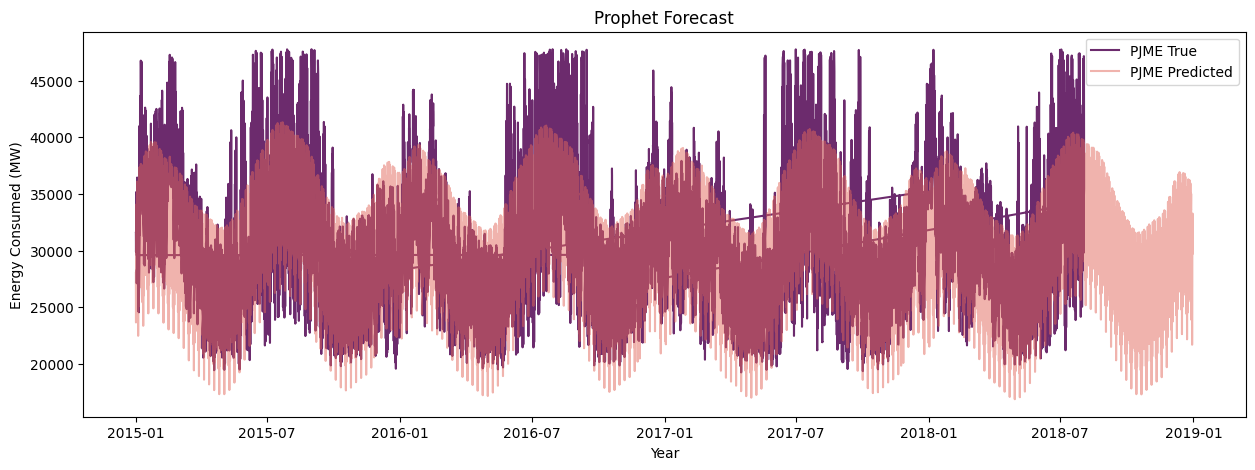

In [130]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(pjme_test.index, pjme_test['PJME_MW'], color=colour_pal[5], label='PJME True')
ax.plot(forecast['ds'], forecast['yhat'], alpha=0.5,
        color=colour_pal[1], label='PJME Predicted')
ax.set(title='Prophet Forecast', xlabel='Year', ylabel='Energy Consumed (MW)')
ax.legend()
plt.show()

### Saving Model for Later